# Part 3.2 Team Comparison

Total records retrieved: 160583

All unique team names in database:
  'Team: Stony Brook'
  'Group: Athletic Performance Staff, Team: Stony Brook'
  'Group: SBU Volleyball, Team: Stony Brook, Team: Stony Brook Women's Volleyball'
  'Group: SBU Volleyball, Team: Stony Brook'
  'Team: Stony Brook Women's Volleyball'
  'Player Not Found'
  'Team: Stony Brook Women's Basketball'
  'Group: Men's Basketball, Group: 21-22, Team: Stony Brook Men's Basketball , Team: Stony Brook'
  'Group: Men's Basketball, Team: Stony Brook'
  'Group: Men's Basketball, Team: Stony Brook Men's Basketball , Team: Stony Brook'
  'Group: msoc, Team: Stony Brook Women's Basketball'
  'Group: msoc, Group: 2023-2024 WBB, Group: Women's Basketball, Team: Stony Brook Women's Basketball'
  'Team: Stony Brook Womens Soccer'
  'Team: Stony Brook, Team: Stony Brook Men's Basketball '
  'Group: Men's Basketball, Group: 21-22, Team: Stony Brook, Team: Stony Brook Men's Basketball '
  'Team: Stony Brook Women's Tennis'
  'Gro

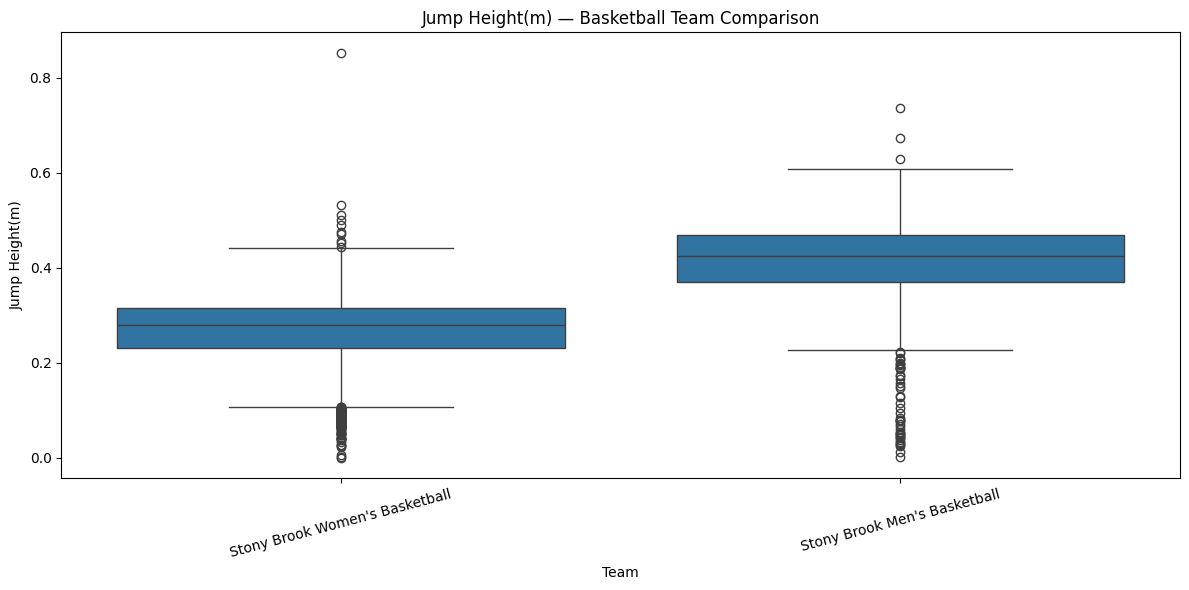


Jump Height(m):
  Stony Brook Women's Basketball: 3178 measurements, Average = 0.27
  Stony Brook Men's Basketball: 2999 measurements, Average = 0.42


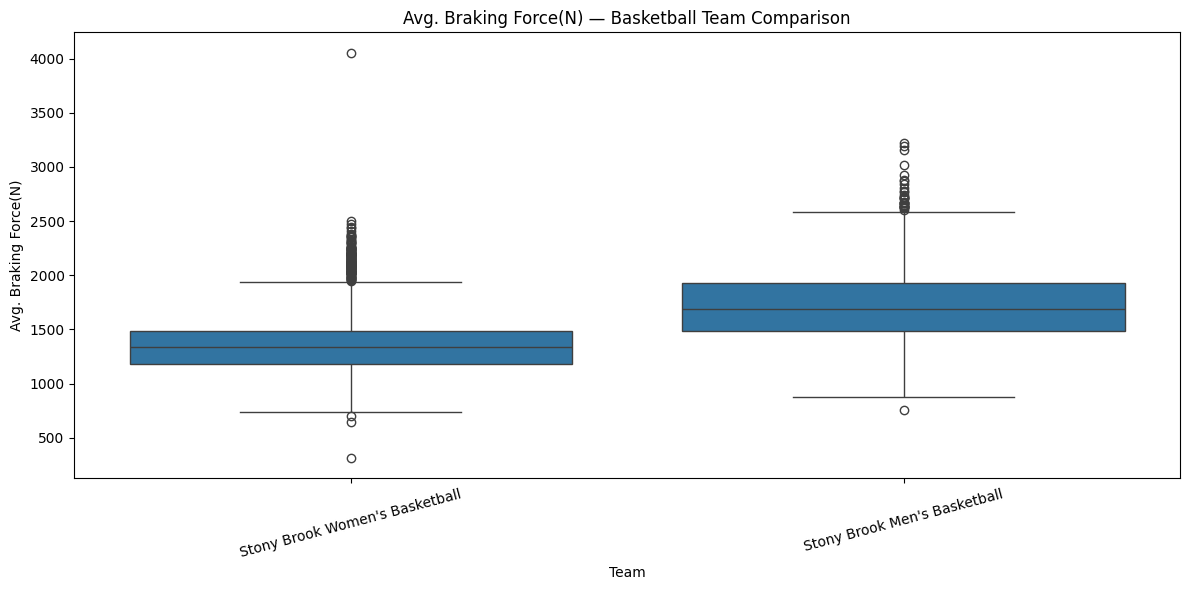


Avg. Braking Force(N):
  Stony Brook Women's Basketball: 3178 measurements, Average = 1345.84
  Stony Brook Men's Basketball: 2990 measurements, Average = 1722.30


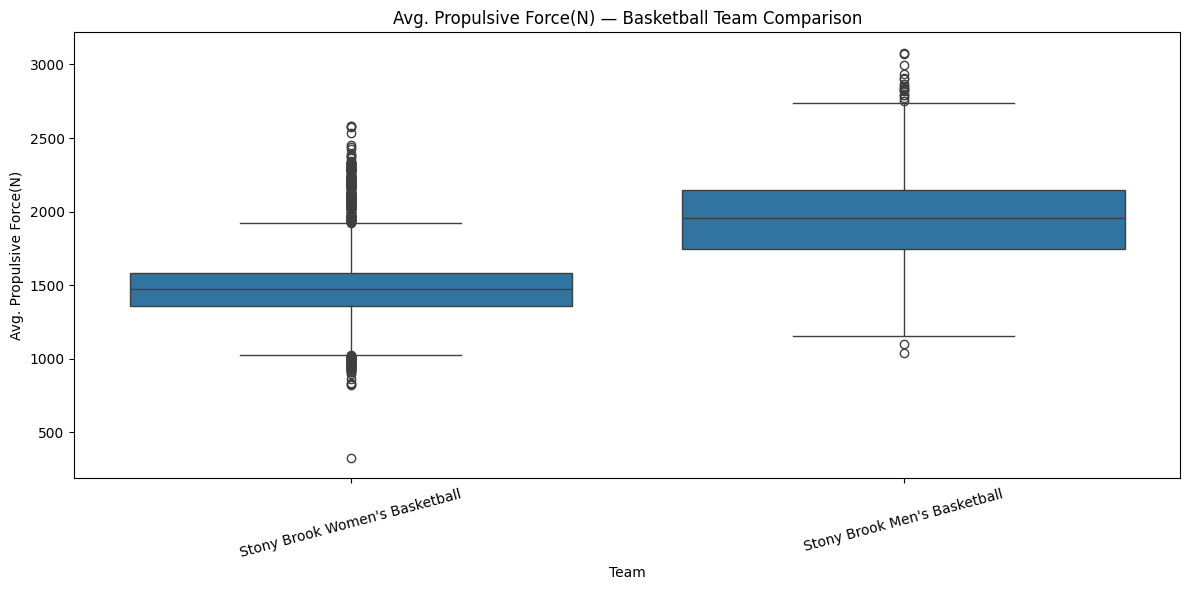


Avg. Propulsive Force(N):
  Stony Brook Women's Basketball: 3178 measurements, Average = 1490.43
  Stony Brook Men's Basketball: 2999 measurements, Average = 1967.25


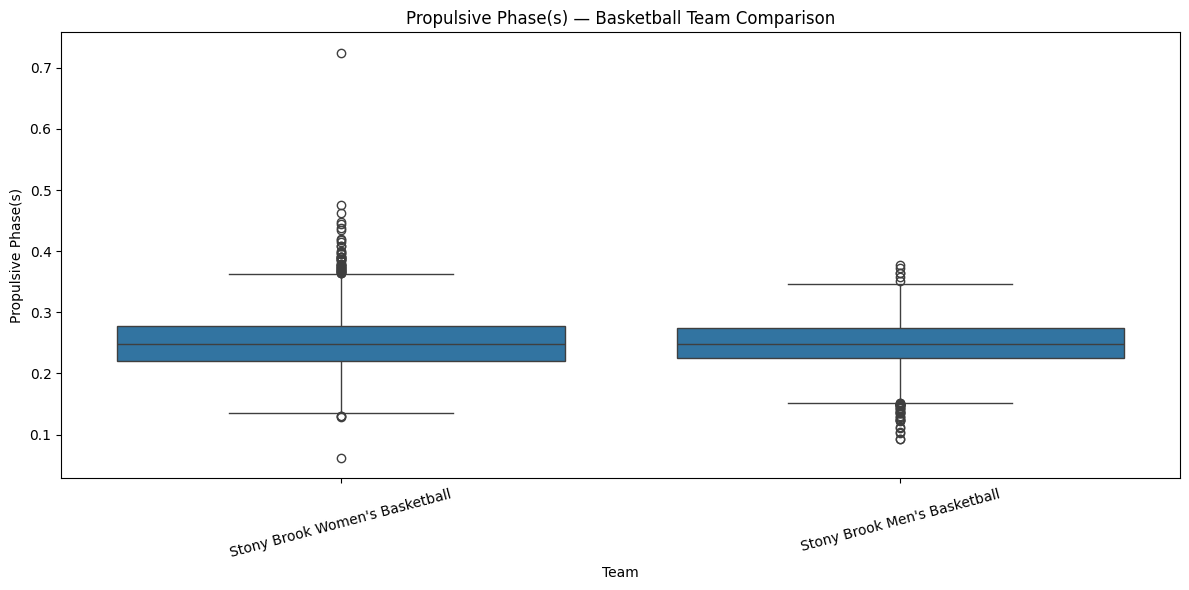


Propulsive Phase(s):
  Stony Brook Women's Basketball: 3178 measurements, Average = 0.25
  Stony Brook Men's Basketball: 2999 measurements, Average = 0.25


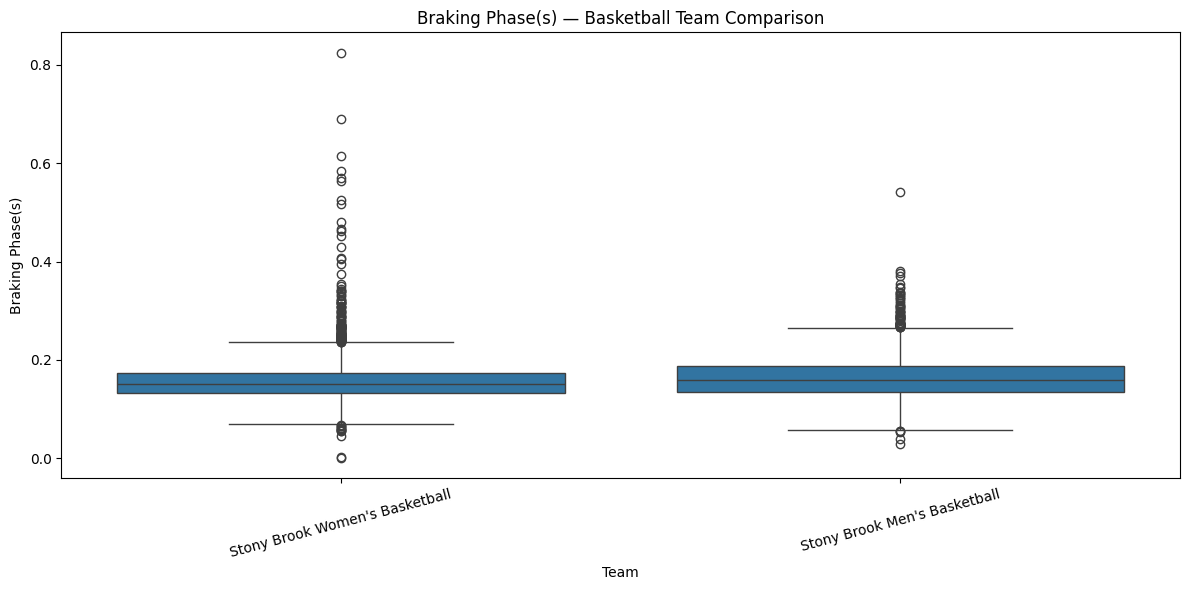


Braking Phase(s):
  Stony Brook Women's Basketball: 3178 measurements, Average = 0.16
  Stony Brook Men's Basketball: 2990 measurements, Average = 0.16


In [7]:
from sqlalchemy import create_engine
import pandas as pd
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from IPython.display import display

# Load database credentials
load_dotenv('test.env')
load_dotenv('test.env', override=True)

sql_username = os.getenv('DB_USER')
sql_password = os.getenv('DB_PASSWORD')
sql_host = os.getenv('DB_HOST')
sql_database = os.getenv('DB_NAME')

# Connect to database
url_string = f"mysql+pymysql://{sql_username}:{sql_password}@{sql_host}:3306/{sql_database}"
conn = create_engine(url_string)

# Metrics we want to compare
selected_metrics = [
    'Jump Height(m)',
    'Avg. Braking Force(N)',
    'Avg. Propulsive Force(N)',
    'Propulsive Phase(s)',
    'Braking Phase(s)'
]

# Get all the data from database
metrics_list = ','.join([f"'{m}'" for m in selected_metrics])
query = f"""
SELECT playername, team, metric, value, timestamp
FROM research_experiment_refactor_test
WHERE metric IN ({metrics_list})
AND team IS NOT NULL
AND team != ''
"""
df = pd.read_sql(query, conn)
print(f"Total records retrieved: {len(df)}")

# First, let's see what teams we have
print("\nAll unique team names in database:")
for team in df['team'].unique()[:20]:  # Show first 20
    print(f"  '{team}'")

# Create a new column that will have the cleaned up team names
df['clean_team'] = df['team'].copy()

# Find all Men's Basketball rows and rename them
for index, row in df.iterrows():
    team_lower = str(row['team']).replace("'", "").replace("'", "").lower()  # Remove all apostrophe types
    
    # Check if it's Men's Basketball (but not Mens Lax)
    if ('mens basketball' in team_lower or 
        'men basketball' in team_lower or
        'mens basketball' in team_lower):
        if 'lax' not in team_lower:  # Make sure it's not lacrosse
            df.loc[index, 'clean_team'] = "Stony Brook Men's Basketball"
    
    # Check if it's Women's Basketball
    if ('womens basketball' in team_lower or 
        'women basketball' in team_lower or
        'womens basketball' in team_lower):
        df.loc[index, 'clean_team'] = "Stony Brook Women's Basketball"

print("\nAfter cleaning - unique clean_team values:")
for team in df['clean_team'].unique()[:20]:  # Show first 20
    print(f"  '{team}'")

# Keep only basketball data
basketball_df = df[df['clean_team'].str.contains('Basketball', na=False)].copy()

mens_count = len(basketball_df[basketball_df['clean_team'] == "Stony Brook Men's Basketball"])
womens_count = len(basketball_df[basketball_df['clean_team'] == "Stony Brook Women's Basketball"])

print(f"\nMen's Basketball records: {mens_count}")
print(f"Women's Basketball records: {womens_count}")

# Create final dataframe with just the columns we need
final_df = pd.DataFrame({
    'playername': basketball_df['playername'].values,
    'team': basketball_df['clean_team'].values,
    'metric': basketball_df['metric'].values,
    'value': basketball_df['value'].values,
    'timestamp': basketball_df['timestamp'].values
})

print("\nFirst few rows:")
print(final_df.head())

if not final_df.empty:
    print("\nTeams we're comparing:")
    for team_name in final_df['team'].unique():
        print(f"  - {team_name}")
else:
    print("\nNo basketball data found!")

# Create comparison plots for each metric
if final_df.empty:
    print("\nNo basketball data found!")
else:
    for metric in selected_metrics:
        # Get data for this specific metric
        metric_data = final_df[final_df['metric'] == metric].copy()
        
        if not metric_data.empty:
            # Create plot
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=metric_data, x='team', y='value')
            plt.title(f"{metric} — Basketball Team Comparison")
            plt.xlabel("Team")
            plt.ylabel(metric)
            plt.xticks(rotation=15)
            plt.tight_layout()
            plt.show()
            
            # Print some statistics
            print(f"\n{metric}:")
            for team in metric_data['team'].unique():
                team_data = metric_data[metric_data['team'] == team]['value'].values
                print(f"  {team}: {len(team_data)} measurements, Average = {team_data.mean():.2f}")
        else:
            print(f"\nNo data found for {metric}")

In [4]:
# Debug cell - run this after your basketball comparison code
print(f"Final DataFrame shape: {final_df.shape}")
print(f"\nUnique teams in final_df:")
for team in final_df['team'].unique():
    print(f"  '{team}'")
print(f"\nUnique metrics: {final_df['metric'].unique()}")
print(f"\nRows per team:")
for team in final_df['team'].unique():
    count = len(final_df[final_df['team'] == team])
    print(f"  {team}: {count} rows")

Final DataFrame shape: (30867, 5)

Unique teams in final_df:
  'Stony Brook Women's Basketball'
  'Stony Brook Men's Basketball'

Unique metrics: ['Avg. Braking Force(N)' 'Avg. Propulsive Force(N)' 'Braking Phase(s)'
 'Jump Height(m)' 'Propulsive Phase(s)']

Rows per team:
  Stony Brook Women's Basketball: 15890 rows
  Stony Brook Men's Basketball: 14977 rows


In [8]:
# Debug cell - run this after your basketball comparison code
print("=== ORIGINAL DATA ===")
print("Actual team names in the original data:")
print(df['team'].unique())

print("\n=== CLEANED DATA ===")
print("Cleaned team names:")
print(df['clean_team'].unique())

print("\n=== BASKETBALL FILTERED DATA ===")
print("Teams in basketball_df:")
print(basketball_df['clean_team'].unique())

print("\n=== FINAL DATA ===")
print("Teams in final_df:")
print(final_df['team'].unique())

# Check data counts per team
print("\nData counts per team in final_df:")
print(final_df.groupby('team').size())

# Check data counts per metric per team
print("\nData counts per metric per team in final_df:")
print(final_df.groupby(['team', 'metric']).size())

=== ORIGINAL DATA ===
Actual team names in the original data:
['Team: Stony Brook'
 'Group: Athletic Performance Staff, Team: Stony Brook'
 "Group: SBU Volleyball, Team: Stony Brook, Team: Stony Brook Women's Volleyball"
 'Group: SBU Volleyball, Team: Stony Brook'
 "Team: Stony Brook Women's Volleyball" 'Player Not Found'
 "Team: Stony Brook Women's Basketball"
 "Group: Men's Basketball, Group: 21-22, Team: Stony Brook Men's Basketball , Team: Stony Brook"
 "Group: Men's Basketball, Team: Stony Brook"
 "Group: Men's Basketball, Team: Stony Brook Men's Basketball , Team: Stony Brook"
 "Group: msoc, Team: Stony Brook Women's Basketball"
 "Group: msoc, Group: 2023-2024 WBB, Group: Women's Basketball, Team: Stony Brook Women's Basketball"
 'Team: Stony Brook Womens Soccer'
 "Team: Stony Brook, Team: Stony Brook Men's Basketball "
 "Group: Men's Basketball, Group: 21-22, Team: Stony Brook, Team: Stony Brook Men's Basketball "
 "Team: Stony Brook Women's Tennis"
 'Group: Football Skill, Team

In [10]:

selected_metrics = [
    'Jump Height(m)',
    'Avg. Braking Force(N)',
    'Avg. Propulsive Force(N)',
    'Propulsive Phase(s)',
    'Braking Phase(s)'
]

# Define the two basketball teams we're comparing
team1 = "Stony Brook Women's Basketball"
team2 = "Stony Brook Men's Basketball"

# Initialize stats_results list
stats_results = []

# Check if we have both teams in the data
if team1 not in final_df['team'].unique() or team2 not in final_df['team'].unique():
    print("Cannot perform statistical tests as one or both basketball teams were not found in the data.")
    print(f"Available teams: {final_df['team'].unique()}")
else:
    print(f"Performing statistical tests comparing {team1} vs {team2}\n")
    
    for metric in selected_metrics:
        team1_vals = final_df[(final_df["team"] == team1) & (final_df["metric"] == metric)]["value"].values
        team2_vals = final_df[(final_df["team"] == team2) & (final_df["metric"] == metric)]["value"].values
        
        # Skip if missing data for either team for the current metric
        if len(team1_vals) < 2 or len(team2_vals) < 2:
            print(f"Skipping t-test for '{metric}' due to insufficient data for one or both teams.")
            continue
        
        tstat, pval = ttest_ind(team1_vals, team2_vals, equal_var=False)
        stats_results.append({
            "metric": metric,
            f"{team1}_mean": team1_vals.mean(),
            f"{team2}_mean": team2_vals.mean(),
            "t-statistic": tstat,
            "p-value": pval
        })
    
    # Only create and display DataFrame if there are results
    if stats_results:
        print("Statistical Test Results:")
        display(pd.DataFrame(stats_results))
    else:
        print("No statistical test results were generated.")

Performing statistical tests comparing Stony Brook Women's Basketball vs Stony Brook Men's Basketball

Statistical Test Results:


,metric,Stony Brook Women's Basketball_mean,Stony Brook Men's Basketball_mean,t-statistic,p-value
0,Jump Height(m),0.267054,0.418863,-76.571251,0.000000e+00
1,Avg. Braking Force(N),1345.841291,1722.304665,-49.220017,0.000000e+00
2,Avg. Propulsive Force(N),1490.434218,1967.248065,-70.671967,0.000000e+00
3,Propulsive Phase(s),0.251447,0.249461,1.866438,6.202809e-02
4,Braking Phase(s),0.157813,0.164150,-5.661737,1.566170e-08


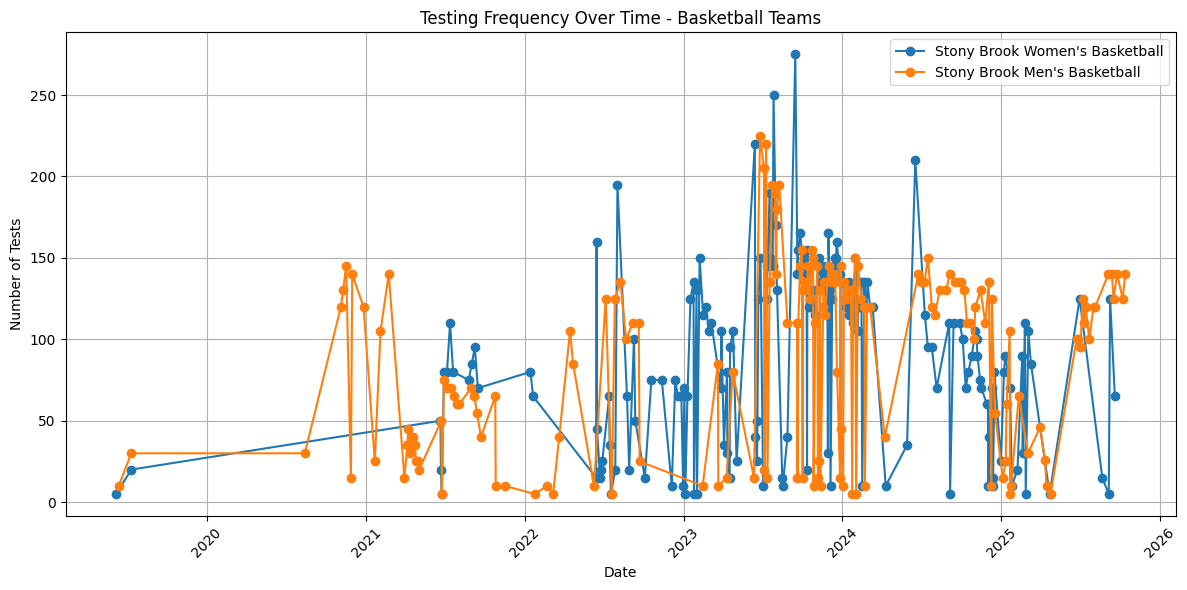

In [13]:
# Create date column from timestamp
final_df["date"] = pd.to_datetime(final_df["timestamp"]).dt.date

# Count tests per date per team
freq = final_df.groupby(["date", "team"]).size().reset_index(name="tests")

# Define the two basketball teams
team1 = "Stony Brook Women's Basketball"
team2 = "Stony Brook Men's Basketball"

# Create the plot
plt.figure(figsize=(12,6))
for t in [team1, team2]:
    sub = freq[freq["team"] == t]
    if not sub.empty:
        plt.plot(sub["date"], sub["tests"], marker="o", label=t)
    else:
        print(f"No data found for {t}")

plt.title("Testing Frequency Over Time - Basketball Teams")
plt.xlabel("Date")
plt.ylabel("Number of Tests")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()